# Introduction

Welcome to Part 2 of the Demography Functions series! Today, we'll be looking at life tables. The end goal of the life table calculation is to find life expectancy. I'll be showing the manual calculations for the life tables but we'll also try to create a function to easily give us life expectancy for any age group. 

One of the key things that we will have to understand as we look at life tables are that there are 2 types of life tables - cohort life tables and period life tables. What's the difference between a cohort and period you might ask? Well, using the diagram below (called a lexis diagram), we see that a cohort is literally a **birth cohort** followed from birth to death. In contrast, a period life table takes a particular slice of time (i.e. a period) and assumes the death rates of each indiviudal birth cohort *within* that period.

![image](https://user-images.githubusercontent.com/68678549/104144223-56060b00-53fd-11eb-83df-664d1116eb34.png)

In this case, for instance, the time between 2001 and 2002 is a **period** while the diagonal movement from 2000 to 2002 is a **cohort**. The life tables for both are sort of similar but different in that for a period life table, it is an "artificial" cohort given that the younger members of the period haven't actually reached the particular ages yet and hence we don't know their **exact** death rate (i.e. we assume that the babies in the period when aged 40 would have the same death rates as the period's 40-year olds).

With this understanding, let's dive right in and start with the simplier cohort life table.

## Key Measure 3 - Life Expectancy from Cohort Life Table

### Theory

Life Tables are all about probabilities. In each column that we create in a life table, we are trying to figure out the probability of one dying or surviving from one age to another. After we know these probabilities, we can then calculate the person-years lived in that particular age group. Person-years is another demographic measure that attempts to estimate the years of time spent alive by persons. It forms the basis as the denominator of rates and we'll look at how to calculate that in the following example. 

### Calculations

So, let's load up our dataset and get cracking on trying to calculate life expectancy from a cohort. (*Note:* All the members of the cohort have already supposedly passed away and this hence allows us to retrospectively calculate what their life expectancies were at each age of life.)

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

So first, we have to calculate probabilities of them surviving from one age group to the next. The dataset that we will import has already split them nicely into the various age groups and so we will be calculating the probabilities of one surviving, dying, and then use those probabilities to calculate the person-years lived. Instead of working with odd numbers, demographers like to choose a round number (known as a ***radix***) which we scale the population to. This is usually a number like 10000 or 100000 - the simulated size of the population at age 0 (i.e. birth). Since we're working with probabilities anyway, this won't change the final outcome but makes it easier to think about the data.

In [29]:
lifetable = pd.read_csv(R"Resources/sweden3.csv") # import the dataset
lifetable["nqx"] = lifetable["deaths"]/lifetable["survivors"] # prob of dying
lifetable["npx"] = 1 - lifetable["nqx"] # prob of surviving
lifetable.loc[0, "lx"] = 10000 # initial radix 

for i in range(1, len(lifetable)):
    lifetable.loc[i, "lx"] = lifetable.loc[i-1,"npx"] * lifetable.loc[i-1, "lx"] # fill radix columns

for i in range(0, len(lifetable)-1):
    lifetable.loc[i, "ndx"] = lifetable.loc[i, "lx"] - lifetable.loc[i+1, "lx"] # number of people who died in that age group

Having calculated the probabilities, here's the tricky bit - calculating the number of person-years lived. We don't know exactly how many of the years within an age interval a person who dies will live (i.e if someone died between 1 - 4, did they die at 1? at 2? or 4? or 3.2?) To resolve this, we need nax, which is an estimate for the average number of person-years lived by someone who died. Using nax, we can then calculate the **total** number of person-years lived by everyone between the respective age groups. We hence usually cheat and estimate nax as being half of the age interval (e.g 2.5 years if the age interval is 5-9, a 5 year age interval) **except for** the first birth interval where the age interval is well, 0. In that case, we usually use the estimate of 0.3 (just a standard convention)

Once we have our nax, we can calculate our nLx - the total number of person-years lived.

In [34]:
lifetable["nax"] = 2.5 #set 2.5 for all 5 year intervals
lifetable.loc[0, "nax"] = 0.3 #set 0.3 for the first interval
lifetable.loc[1, "nax"] = 2.0 #set 2.0 for the second interval because it is only a 4 year interval of 1-4

lifetable["n"] = 5 # set the width of the age range to 5
lifetable.loc[0, "n"] = 1 #set 1 for the first interval
lifetable.loc[1, "n"] = 4.0 #set 4.0 for the second interval because it is a 4 year interval of 1-4

for i in range(0, len(lifetable)-1):
    lifetable.loc[i, "nLx"] = (lifetable.loc[i, "nax"]*lifetable.loc[i, "ndx"])  + (lifetable.loc[i+1, "lx"]*lifetable.loc[i,"n"])

Finally, we need to calculate the total years left to live by cumulatively summing up the nLx for each age range. Then, we can finally get our life expectancy by dividing the total years left to live for a particular age group by the number of people (lx) in that age group.

Text(0.5, 1.0, 'Life Expectancy for a cohort')

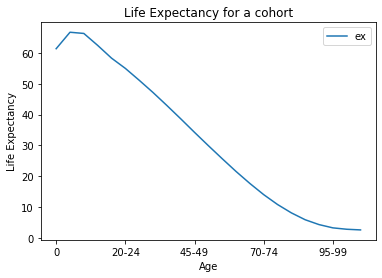

In [44]:
lifetable['Tx'] = lifetable.loc[::-1, 'nLx'].cumsum()[::-1] # perform a reverse cumulative sum
lifetable["ex"] = lifetable["Tx"] / lifetable["lx"] # calculate life expectancy at each age group

lifetable.plot(x="age", y="ex")
plt.xlabel("Age")
plt.ylabel("Life Expectancy")
plt.title("Life Expectancy for a cohort")

Notice how the life expectancy rises slightly after birth. This is particularly noticed in less economically developed countries where the infant mortality rate is extremely high and hence one has a better chance of suriving life once one passes the infant stage. But with that, we're done with the cohort life table and life expectancy! 

## Key Measure 4 - Period Life Expectancy 

### Theory

But see, the issue with doing cohort life expectancies is that the data takes forever to collect. We have to wait for the **ENTIRE** cohort to be birthed and die before we can fully calculate these measures. Hence, a period life table is typically more useful because it creates a synthetic cohort and allows for *projections*. The calucations are similar but different in that instead of using probabilities, we have to use age-specific death rates ([link to the previous article](https://zachlim98.github.io/me/2021-01/Demog-Functions-part1) if didn't read about ASDRs). This is because we don't have probabilities yet! This synthetic cohort hasn't actually died yet so we don't have exact numbers to give us probabilities. Instead, we use ASDRs as estimations. 

As such, we introduce a new measure - nmx. nmx is essentially the ASDR and we use the [Greville-Chiang conversion](https://www.jstor.org/stable/2682293) to convert nmx to our previously used nqx. And... that's essentially the only difference in terms of calculations. Once that's done, we basically follow the exact same steps as per the cohort life table.

### Calculations 

Load up the new resources provided. This time, we'll be look at the period of 2014 for Japan. We are givin the nNx (the mid year population count) as well as the nDX (the death count). We are also provided the nax so we don't have to calculate it ourselves. Finally, we have n, which is the width of the population interval. 

Text(0.5, 1.0, 'Life Expectancy for Japan (2014 Period)')

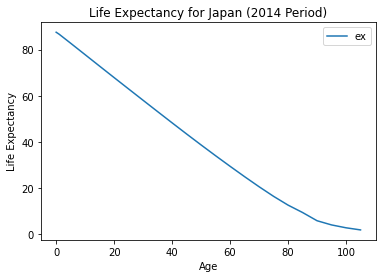

In [73]:
japan = pd.read_csv(R"Resources/japan4.csv") #import the file
japan["nmx"] = japan["nDx"]/japan["nNx"] #calculate the ASDR or nmx

japan["nqx"] = (japan["n"]*japan["nmx"]/(1+(japan["n"]-japan["nax"])*japan["nmx"])) #perform the Greville-Chiang conversion to find nqx
japan["npx"] = 1-japan["nqx"] #calculate nqx

# from here, it is essentially the same and hence I won't provide more markdown commentary 

japan.loc[0, "lx"] = 10000 # initial radix 

for i in range(1, len(japan)):
    japan.loc[i, "lx"] = japan.loc[i-1,"npx"] * japan.loc[i-1, "lx"] # fill radix columns

for i in range(0, len(japan)-1):
    japan.loc[i, "ndx"] = japan.loc[i, "lx"] - japan.loc[i+1, "lx"] # number of people who died in that age group

for i in range(0, len(japan)-1):
    japan.loc[i, "nLx"] = (japan.loc[i, "nax"]*japan.loc[i, "ndx"])  + (japan.loc[i+1, "lx"]*japan.loc[i,"n"])

japan['Tx'] = japan.loc[::-1, 'nLx'].cumsum()[::-1] # perform a reverse cumulative sum
japan["ex"] = japan["Tx"] / japan["lx"] # calculate life expectancy at each age group

japan.plot(x="Age", y="ex")
plt.xlabel("Age")
plt.ylabel("Life Expectancy")
plt.title("Life Expectancy for Japan (2014 Period)")

Yay, we're done! But wait... if you check the dataframe, you'll see that its "NaN" for the last 110+ cohort. The issue here is that for the last cohort, its an open-ended cohort which means that nqx should technically be **1** since everyone dies and has to exit the cohort. Yet, we don't have exact data for that since some of the members in the age group have not died (again, because this is a *slice* in time).

Hence, we have to make a slight adjustment. For the open-ended cohort, we calculate nLx as lx/nmx. We do this because the "n" here is technically infinity, given that we don't actually know how long they will live for. 

Text(0.5, 1.0, 'Life Expectancy for Japan (2014 Period, Adjusted for Open-Ended Cohort)')

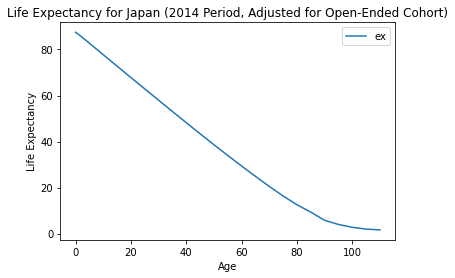

In [79]:
japan.loc[len(japan)-1,"nLx"] = japan.loc[len(japan)-1,"lx"]/japan.loc[len(japan)-1,'nmx'] #fill in lx for open ended cohort

japan['Tx'] = japan.loc[::-1, 'nLx'].cumsum()[::-1] # perform a reverse cumulative sum
japan["ex"] = japan["Tx"] / japan["lx"] # calculate life expectancy at each age group

japan.plot(x="Age", y="ex")
plt.xlabel("Age")
plt.ylabel("Life Expectancy")
plt.title("Life Expectancy for Japan (2014 Period, Adjusted for Open-Ended Cohort)")